In [1]:
#Importing necesary data pacakages
import rasterio 
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
from skimage import io
import time
from skimage import data, img_as_float
import cv2
import math

**Exercise 1**

1. Load an urban remote sensing image (US-like)

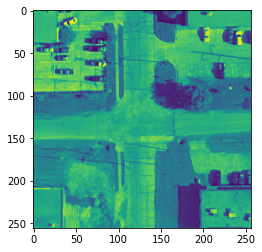

In [2]:
img = cv2.imread('intersection23.tif',1)
org_img = img
# convert image to gray
im_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#threshold gray image to b and w
ret,thresh2 = cv2.threshold(im_gray,120,255,cv2.THRESH_BINARY_INV)

plt.imshow(im_gray)

2. Extract the road junctions with Harris detector

Text(0.5, 1.0, 'image with corners')

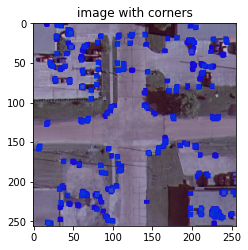

In [3]:
# dilate and erode image
kernel = np.ones((5,5), np.uint8)
img_dilation = cv2.dilate(thresh2, kernel, iterations=2)

kernel = np.ones((10,10), np.uint8)
img_erosion = cv2.erode(img_dilation, kernel, iterations=1)

# detect corners
gray = np.float32(img_erosion)
dst = cv2.cornerHarris(gray,3,5,0.06)
dst = cv2.dilate(dst,None,iterations=2)
img[dst>0.01*dst.max()]=[0,0,255]

plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(org_img)
# plt.title("original image")
# plt.subplot(122)
plt.imshow(dst,alpha=0.3)
plt.title("image with corners")

3. Compute the main road orientations with Hough transform

Hough transform is a feature extraction method for detecting simple shapes such as circles, lines, etc in an image. As you know, a line in the image space can be expressed with two variables: in **Cartesian coordinate system** and **polar coordinate system**.For Hough Transforms, we can express lines in the Polar system whose line equation can be written as: $$y=\left(-\frac{\cos \theta}{\sin \theta}\right) x+\left(\frac{r}{\sin \theta}\right)
$$ When arranging these terms, we get: $r=x \cos \theta+y \sin \theta$

In general for each point $(x0,y0)$, we can define the family of lines that goes through that point.It means that in general, a line can be detected by finding the number of intersections between curves.The more curves intersecting means that the line represented by that intersection have more points. In general, we can define a threshold of the minimum number of intersections needed to detect a line.
This is what the Hough Line Transform does. It keeps track of the intersection between curves of every point in the image. If the number of intersections is above some threshold, then it declares it as a line with the parameters $(\theta,r_{\theta})$ of the intersection point.

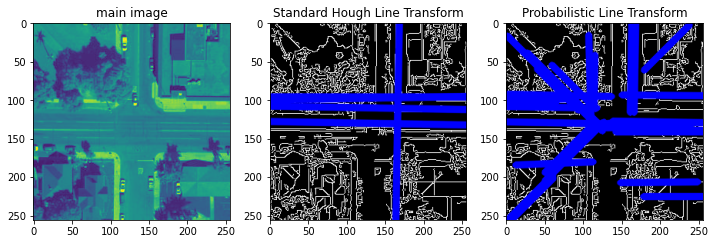

In [4]:
# Loads another image
src = cv2.imread(cv2.samples.findFile('intersection94.jpg'), cv2.IMREAD_GRAYSCALE)
dst1 = cv2.Canny(src, 100, 20, None, 3)

# Copy edges to the images that will display the results in BGR
cdst = cv2.cvtColor(dst1, cv2.COLOR_GRAY2BGR)
cdstP = np.copy(cdst)

# Standard Hough Line Transform
lines = cv2.HoughLines(dst1, 1, np.pi / 180, 125, None, 0, 0)
#standard parameter(out_edge, detected_lines, rho_resolution, theta, threshold_detect, srn and stn )

# display the result by drawing the lines.
if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv2.line(cdst, pt1, pt2, (0,0,255), 7, cv2.LINE_AA)

# Probabilistic Line Transform
linesP = cv2.HoughLinesP(dst1, 1, np.pi / 180, 100, None, 50, 10)
#with param(out_edge, detected_lines, rho_resolution, theta, threshold_detect, minLine_pts, maxLinegap)

#display the result by drawing the lines
if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        cv2.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0,0,255), 7, cv2.LINE_AA)

# Display the original image and the detected lines
plt.figure(figsize=(12,10))
plt.subplot(131)
plt.imshow(src)
plt.title('main image')
plt.subplot(132)
plt.imshow(cdst)
plt.title('Standard Hough Line Transform')
plt.subplot(133)
plt.imshow(cdstP)
plt.title("Probabilistic Line Transform")
plt.show()

The blue line are the detected line. The visualization for this lines can be changed with the change in threshold.

**Exercise 2**

1. Download the UC Merced Land Use dataset
2. Select randomly 10 images per class
3. Compute the Haralick features for these images
4. Apply a basic retrieval scheme through computing features on an input image and looking for its nearest neighbors among the reference images

Haralick Texture is used to quantify an image based on texture. The Haralick texture features are functions of the normalized GLCM, where different aspects of the gray level distribution in the ROI are represented. Gray Level Co-occurrence matrix (GLCM) uses adjacency concept in images. The basic idea is that it looks for pairs of adjacent pixel values that occur in an image and keeps recording it over the entire image. 

In [5]:
import os
import glob
import mahotas as mt
from sklearn.neighbors import KNeighborsClassifier

In [6]:
# load the training dataset
train_path = "dataset/train"    #the path to training dataset
train_names = os.listdir(train_path)    #the class names of the training data

# empty list to hold feature vectors and train labels
train_features = []
train_labels = []

In [7]:
#extraction of features

# a function that takes an input image to compute haralick texture
def extract_features(image):
    # calculate haralick texture features for 4 types of adjacency
    textures = mt.features.haralick(image)
    # take the mean of it and return it
    ht_mean = textures.mean(axis=0)
    return ht_mean

In [8]:
# loop over the training dataset
print ("[STATUS] Started extracting haralick textures..")
#loops over the training labels we have just included from training directory
for train_name in train_names:
    #path to current image class directory
    cur_path = train_path + "/" + train_name
    #holds the current image class label
    cur_label = train_name
    i = 1
    #takes all the files with .tif as the extension and loops through each file one by one
    for file in glob.glob(cur_path + "/*.tif"):
        print ("Processing Image - {} in {}".format(i, cur_label))
        # reads the input image that corresponds to a file
        image = cv2.imread(file)

        # convert the image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # extract haralick texture from the image
        features = extract_features(gray)

         # append the feature vector and label
        train_features.append(features)
        train_labels.append(cur_label)

        # show loop update
        i += 1

[STATUS] Started extracting haralick textures..
Processing Image - 1 in tennis
Processing Image - 2 in tennis
Processing Image - 3 in tennis
Processing Image - 4 in tennis
Processing Image - 5 in tennis
Processing Image - 6 in tennis
Processing Image - 7 in tennis
Processing Image - 8 in tennis
Processing Image - 9 in tennis
Processing Image - 10 in tennis
Processing Image - 1 in beach
Processing Image - 2 in beach
Processing Image - 3 in beach
Processing Image - 4 in beach
Processing Image - 5 in beach
Processing Image - 6 in beach
Processing Image - 7 in beach
Processing Image - 8 in beach
Processing Image - 9 in beach
Processing Image - 10 in beach
Processing Image - 1 in buildings
Processing Image - 2 in buildings
Processing Image - 3 in buildings
Processing Image - 4 in buildings
Processing Image - 5 in buildings
Processing Image - 6 in buildings
Processing Image - 7 in buildings
Processing Image - 8 in buildings
Processing Image - 9 in buildings
Processing Image - 10 in buildings

In [9]:
# size of our feature vector and labels
print("Training features: {}".format(np.array(train_features).shape))
print("Training labels: {}".format(np.array(train_labels).shape))

Training features: (40, 13)
Training labels: (40,)


In [10]:
#defining nn classifier
model = KNeighborsClassifier(n_neighbors=3)

# Train the model using the training sets
model.fit(train_features,train_labels)

KNeighborsClassifier(n_neighbors=3)

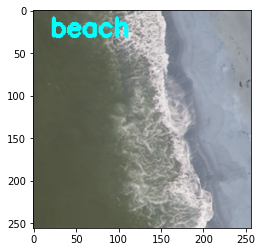

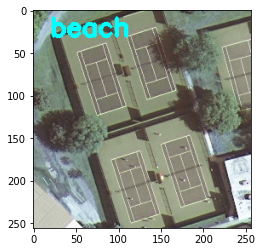

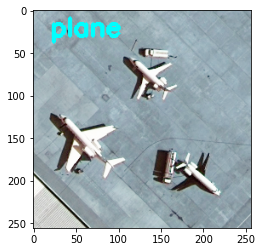

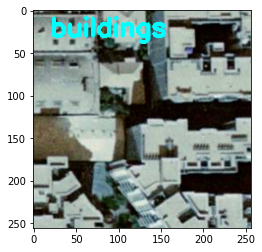

In [11]:
# loop over the test images
test_path = "dataset/test"
image = []
for file in glob.glob(test_path + "/*.tif"):
    # read the input image
    image = cv2.imread(file)

    # convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # extract haralick texture from the image
    features = extract_features(gray)
    
    # evaluate the model and predict label
    predicted= model.predict(features.reshape(1, -1))[0]
    # prediction = clf_svm.predict(features.reshape(1, -1))[0]

    # show the label
    cv2.putText(image, predicted, (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,255), 3)

    # display the output image
    plt.imshow(image)
    plt.show()

I was not able to lable all 4 test image correctly in any of my run, which I believe is due to poor setting of the paramter and moreover less training dataset. 